<a href="https://colab.research.google.com/github/chnychny/SignalProcessing/blob/main/%5B3%EC%9D%BC%EC%B0%A8_%EC%98%A4%ED%9B%84_%EC%8B%A4%EC%8A%B5_%EB%8B%B5%EC%95%88%5D%5BAI_%EC%8B%9C%EA%B0%81_%EC%9D%91%EC%9A%A9%EA%B3%BC%EC%A0%95%5D_Coding_Lecture__Object_Detection_(Answer)_ipynb_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection
이번 시간에는 object detection에 대해 실습하는 시간을 가져봅니다.
이번 실습을 통해 object detection 모델 중 하나인 YOLO(v1)을 코드로 구현하고
모델을 트레이닝 및 평가하기 위한 프레임워크를 구현합니다.
트레이닝한 후, 정량적인 결과와 모델 출력 예시를 확인합니다.

(아래 코드는 https://github.com/JeffersonQin/yolo-v1-pytorch 를 바탕으로 작성되었음을 밝힙니다.)

## 0. Import Necessary Modules
Object detection을 구현하기 위해 관련된 모듈들을 불러옵니다.

In [ ]:
import os
import cv2
import math
import json
import torch
import random
import numpy as np
import torchvision
from torch import nn
from enum import Enum
from PIL import Image
from IPython import display
from tqdm import tqdm, trange
from functools import cmp_to_key

## 1. Dataset & Data Loader
모델 학습 및 평가에 사용될 데이터셋을 불러옵니다.
본 실습에서는 VOC 2007, VOC 2012 데이터셋을 사용합니다.

In [ ]:
categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


# Dataset adapt for Yolo format (divided into cells)
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, train=True):
        self.dataset = dataset
        self.train = train

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, target = self.dataset[idx]

        if not isinstance(target['annotation']['object'], list):
            target['annotation']['object'] = [target['annotation']['object']]
        count = len(target['annotation']['object'])

        height, width = int(target['annotation']['size']['height']), int(target['annotation']['size']['width'])

        # Image Augmentation
        if self.train:
            # randomly scaling and translation up to 20%
            if random.random() < 0.5:
                # use random value to decide scaling factor on x and y axis
                random_height = random.random() * 0.2
                random_width = random.random() * 0.2
                # use random value again to decide scaling factor for 4 borders
                random_top = random.random() * random_height
                random_left = random.random() * random_width
                # calculate new width and height and position
                top = random_top * height
                left = random_left * width
                height = height - random_height * height
                width = width - random_width * width
                # crop image
                img = torchvision.transforms.functional.crop(img, int(top), int(left), int(height), int(width))

                # update target
                for i in range(count):
                    obj = target['annotation']['object'][i]
                    obj['bndbox']['xmin'] = max(0, float(obj['bndbox']['xmin']) - left)
                    obj['bndbox']['ymin'] = max(0, float(obj['bndbox']['ymin']) - top)
                    obj['bndbox']['xmax'] = min(width, float(obj['bndbox']['xmax']) - left)
                    obj['bndbox']['ymax'] = min(height, float(obj['bndbox']['ymax']) - top)

            # adjust saturation randomly up to 150%
            if random.random() < 0.5:
                random_saturation = random.random() + 0.5
                img = torchvision.transforms.functional.adjust_saturation(img, random_saturation)

        # resize to 448*448
        img = torchvision.transforms.functional.resize(img, (448, 448))

        # update labels from absolute to relative
        height, width = float(height), float(width)

        for i in range(count):
            obj = target['annotation']['object'][i]
            obj['bndbox']['xmin'] = float(obj['bndbox']['xmin']) / width
            obj['bndbox']['ymin'] = float(obj['bndbox']['ymin']) / height
            obj['bndbox']['xmax'] = float(obj['bndbox']['xmax']) / width
            obj['bndbox']['ymax'] = float(obj['bndbox']['ymax']) / height

        # Label Encoding
        # [{'name': '', 'xmin': '', 'ymin': '', 'xmax': '', 'ymax': '', }, {}, {}, ...]
        # ==>
        # [x, y  (relative to cell), width, height, 1 if exist (confidence),
        #  x, y  (relative to cell), width, height, 1 if exist (confidence),
        #  one-hot encoding of 20 categories]
        label = torch.zeros((7, 7, 30))
        for i in range(count):
            obj = target['annotation']['object'][i]
            xmin = obj['bndbox']['xmin']
            ymin = obj['bndbox']['ymin']
            xmax = obj['bndbox']['xmax']
            ymax = obj['bndbox']['ymax']
            name = obj['name']

            if xmin == xmax or ymin == ymax:
                continue
            if xmin >= 1 or ymin >= 1 or xmax <= 0 or ymax <= 0:
                continue

            x = (xmin + xmax) / 2.0
            y = (ymin + ymax) / 2.0

            width = xmax - xmin
            height = ymax - ymin

            xidx = math.floor(x * 7.0)
            yidx = math.floor(y * 7.0)

            # According to the paper
            # if multiple objects exist in the same cell
            # pick the one with the largest area
            if label[yidx][xidx][4] == 1:  # already have object
                if label[yidx][xidx][2] * label[yidx][xidx][3] < width * height:
                    use_data = True
                else:
                    use_data = False
            else:
                use_data = True

            if use_data:
                for offset in [0, 5]:
                    # Transforming image relative coordinates to cell relative coordinates:
                    # x - idx / 7.0 = x_cell / cell_count (7.0)
                    # => x_cell = x * cell_count - idx = x * 7.0 - idx
                    # y is the same
                    label[yidx][xidx][0 + offset] = x * 7.0 - xidx
                    label[yidx][xidx][1 + offset] = y * 7.0 - yidx
                    label[yidx][xidx][2 + offset] = width
                    label[yidx][xidx][3 + offset] = height
                    label[yidx][xidx][4 + offset] = 1
                label[yidx][xidx][10 + categories.index(name)] = 1

        return img, label


# Raw Dataset for testing mAP, Precision and Recall
# Target are
class VOCRawTestDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, target = self.dataset[idx]

        if not isinstance(target['annotation']['object'], list):
            target['annotation']['object'] = [target['annotation']['object']]
        count = len(target['annotation']['object'])

        height, width = int(target['annotation']['size']['height']), int(target['annotation']['size']['width'])

        # resize to 448*448
        img = torchvision.transforms.functional.resize(img, (448, 448))

        # update labels from absolute to relative
        height, width = float(height), float(width)

        ret_targets = []

        for i in range(count):
            obj = target['annotation']['object'][i]

            ret_targets.append({
                'xmin': float(obj['bndbox']['xmin']) / width,
                'ymin': float(obj['bndbox']['ymin']) / height,
                'xmax': float(obj['bndbox']['xmax']) / width,
                'ymax': float(obj['bndbox']['ymax']) / height,
                'category': categories.index(obj['name']),
                'difficult': obj['difficult'] == '1',
            })

        return img, json.dumps(ret_targets)


root = 'data'
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset_train = VOCDataset(
    torch.utils.data.ConcatDataset([
        torchvision.datasets.VOCDetection(
            root=root, year=year, image_set=image_set, download=True, transform=transform
        ) for year, image_set in [('2007', 'trainval'), ('2007', 'test'), ('2012', 'train')]
    ]), train=True
)
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2)

dataset_val = VOCDataset(
    torch.utils.data.ConcatDataset([
        torchvision.datasets.VOCDetection(
            root=root, year=year, image_set=image_set, download=True, transform=transform
        ) for year, image_set in [('2012', 'val')]
    ]), train=False
)
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=2)

dataset_val_raw = VOCRawTestDataset(
    torch.utils.data.ConcatDataset([
        torchvision.datasets.VOCDetection(
            root=root, year=year, image_set=image_set, download=True, transform=transform
        ) for year, image_set in [('2012', 'val')]
    ])
)
loader_val_raw = torch.utils.data.DataLoader(dataset_val_raw, batch_size=16, shuffle=False, num_workers=2)


Using downloaded and verified file: data/VOCtrainval_06-Nov-2007.tar
Extracting data/VOCtrainval_06-Nov-2007.tar to data
Using downloaded and verified file: data/VOCtest_06-Nov-2007.tar
Extracting data/VOCtest_06-Nov-2007.tar to data
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


## 2. YOLO v1 Architecture (**Need to be implemented!**)
YOLO v1 모델을 구현합니다.
YOLO v1 모델은 아래와 같이 크게 세 부분으로 구현되어 있습니다.
- (Frozen) ImageNet-pretrained ResNet-18
- Convolution layers (w/ BatchNorms, non-linear activations)
- Fully-connected layers (w/ non-linear activations)

이번 시간에는 아래 도표를 참고하여 YOLO v1 모델을 직접 구현합니다.
구체적인 hyperparameters들은 도표를 참고하시면 됩니다.

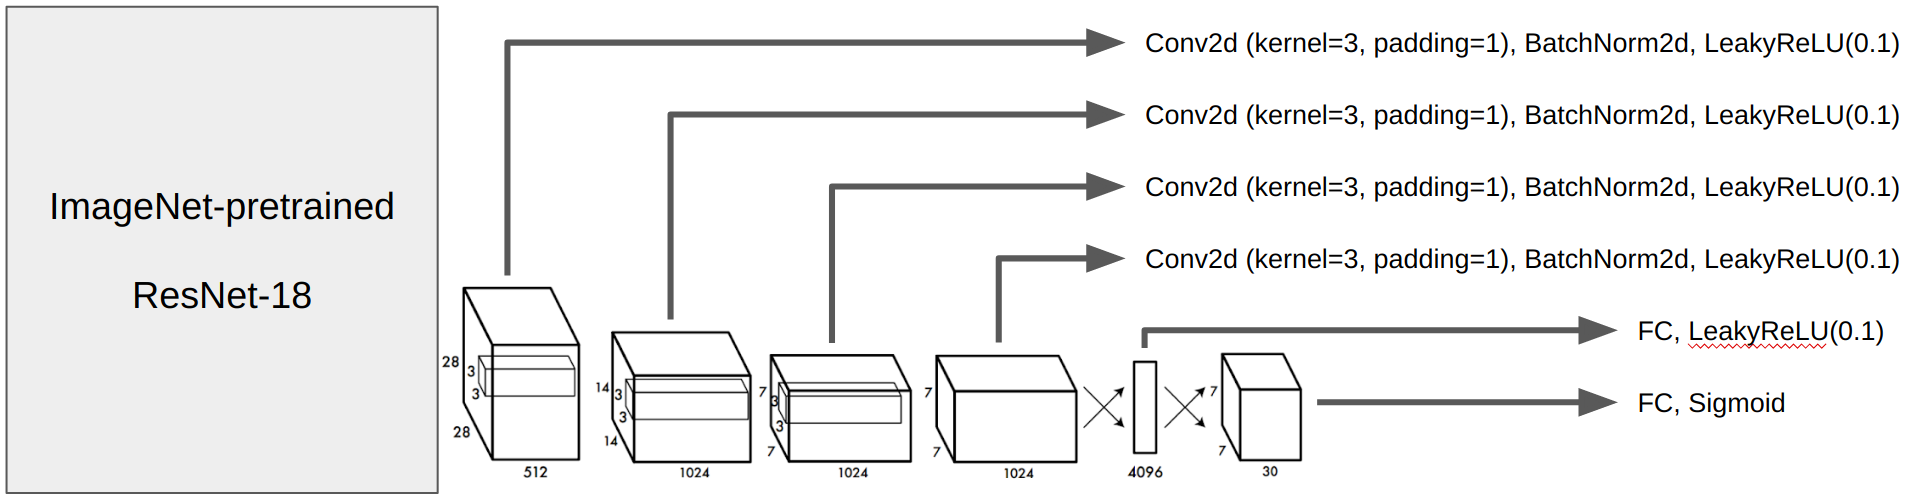

In [ ]:
# YOLO v1 architecture
class Yolo(nn.Module):
    def __init__(self):
        super(Yolo, self).__init__()
        # ResNet-18 Backbone (frozen)
        #  1. Load a pretrained ResNet-18 from torchvision.
        #  2. Remove two layers (i.e., pooling and fc) at the end of ResNet-18.
        #  3. Freeze the parameters of the pretrained network.
        self.backbone = torchvision.models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        for p in self.backbone.parameters():
            p._requires_grad = False

        # YOLO Detection Head
        self.head = nn.Sequential(
            # Conv-BatchNorm-LeakyReLU
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),

            # Conv-BatchNorm-LeakyReLU
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),

            # Conv-BatchNorm-LeakyReLU
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),

            # Conv-BatchNorm-LeakyReLU
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),

            # Flattening for FC layers
            nn.Flatten(),

            # FC-LeakyReLU
            nn.Linear(7*7*1024, 4096),
            nn.LeakyReLU(0.1, inplace=True),

            # FC-Sigmoid
            nn.Linear(4096, 7*7*30),
            nn.Sigmoid(),

            # Unflattening for the output
            nn.Unflatten(1, (7, 7, 30))
        )

    def forward(self, x):
        return self.head(self.backbone(x))

# Instantiation of YOLO v1
net = Yolo().cuda()

# Initialize YOLO with the pretrained weight
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ATVerXuOYXdQDxReHOgA8LJPZx75vdbn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ATVerXuOYXdQDxReHOgA8LJPZx75vdbn" -O pretrained.pth && rm -rf /tmp/cookies.txt
net.load_state_dict(torch.load('pretrained.pth'))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--2022-08-31 05:40:03--  https://docs.google.com/uc?export=download&confirm=t&id=1ATVerXuOYXdQDxReHOgA8LJPZx75vdbn
Resolving docs.google.com (docs.google.com)... 142.250.4.113, 142.250.4.102, 142.250.4.101, ...
Connecting to docs.google.com (docs.google.com)|142.250.4.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7q8io7j2237hc773huvgpni4on3b8mkl/1661924400000/06028116174128453582/*/1ATVerXuOYXdQDxReHOgA8LJPZx75vdbn?e=download&uuid=3b84bddb-1a0a-4657-ae56-b3bf096e886a [following]
--2022-08-31 05:40:04--  https://doc-08-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7q8io7j2237hc773huvgpni4on3b8mkl/1661924400000/06028116174128453582/*/1ATVerXuOYXdQDxReHOgA8LJPZx75vdbn?e=download&uuid=3b84bddb-1a0a-4657-ae56-b3bf096e886a
Resolving doc-08-bo-docs.googleusercontent.com (doc-08-bo-docs.googleusercontent.com)... 142.251.10.132, 2404

<All keys matched successfully>

## 3. Detection Loss (**Need to be implemented!**)
YOLO v1 모델을 훈련하기 위한 손실 함수를 정의합니다.
손실 함수는 논문에 나온 바와 같이 크게 5가지 term으로 구성됩니다.
- (loss_1) Box coordinates (top-left)
- (loss_2) Box coordinates (width & height)
- (loss_3) Confidences of boxes that DO include objects
- (loss_4) Confidences of boxes that DO NOT include objects
- (loss_5) Class probabilities

구현의 편의를 위해 몇 가지 유용한 함수를 제공합니다.
- calc_iou: box coordinates이 주어졌을 때 IoU를 계산합니다.
- calc_indicator: 각 셀에 object가 존재하는지 판단합니다.

이번 실습 시간에는 위 함수들을 이용하여 손실 함수를 구현합니다 (loss_1 ~ loss_5).

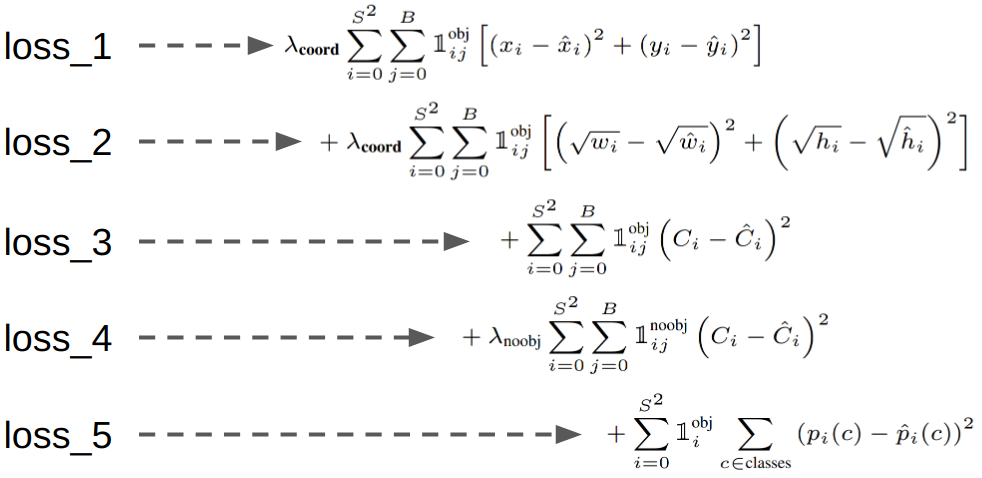

In [ ]:
# Calculate IoU with bounding box
def calc_iou(y_area, yhat_area):
    # Transform cell relative coordinates to image relative coordinates
    def calc_coord(box_area):
        with torch.no_grad():
            # arrange cell xidx, yidx
            # [7, 7]
            cell_xidx = (torch.arange(49) % 7).reshape(7, 7)
            cell_yidx = (torch.div(torch.arange(49), 7, rounding_mode='floor')).reshape(7, 7)
            # transform to [7, 7, 2]
            cell_xidx.unsqueeze_(-1)
            cell_yidx.unsqueeze_(-1)
            cell_xidx.expand(7, 7, 2)
            cell_yidx.expand(7, 7, 2)
            cell_xidx = cell_xidx.to(box_area.device)
            cell_yidx = cell_yidx.to(box_area.device)

            x = (box_area[..., 0] + cell_xidx) / 7.0
            y = (box_area[..., 1] + cell_yidx) / 7.0

            return (x - box_area[..., 2] / 2.0,
                    x + box_area[..., 2] / 2.0,
                    y - box_area[..., 3] / 2.0,
                    y + box_area[..., 3] / 2.0)

    with torch.no_grad():
        x_min, x_max, y_min, y_max = calc_coord(y_area)
        x_min_hat, x_max_hat, y_min_hat, y_max_hat = calc_coord(yhat_area)

        wi = torch.min(x_max, x_max_hat) - torch.max(x_min, x_min_hat)
        wi = torch.max(wi, torch.zeros_like(wi))
        hi = torch.min(y_max, y_max_hat) - torch.max(y_min, y_min_hat)
        hi = torch.max(hi, torch.zeros_like(hi))

        intersection = wi * hi
        union = (x_max - x_min) * (y_max - y_min) + (x_max_hat - x_min_hat) * (y_max_hat - y_min_hat) - intersection
        iou = intersection / (union + 1e-6)

        # select one bounding box per each grid (res shape == [B, 7, 7, 1])
        _, res = iou.max(dim=3, keepdim=True)

    return res

# Calculate Indicator matrix [B, 7, 7]
def calc_indicator(inp):
    have_obj = inp[..., 4] > 0  # [B, 7, 7] Existence of objects in each grid
    no_obj = ~have_obj          # [B, 7, 7] Absence of objects in each grid

    return have_obj, no_obj

# Detection Loss
def criterion(yhat, y):
    """
    Args:
        yhat: [#, 7, 7, 30] (predicted)
        y: [#, 7, 7, 30] (ground-truth)
    Returns:
        loss: [#]
    """

    # Split into bounding box and class probability
    y_area = y[..., :10].reshape(-1, 7, 7, 2, 5)        # Two bounding boxes (x,y,w,h) in each grid (7x7)
    yhat_area = yhat[..., :10].reshape(-1, 7, 7, 2, 5)  # Two bounding boxes (x,y,w,h) in each grid (7x7)

    y_class = y[..., 10:].reshape(-1, 7, 7, 20)         # Class probabilities of 20 classes
    yhat_class = yhat[..., 10:].reshape(-1, 7, 7, 20)   # Class probabilities of 20 classes 

    # Calculate IoU with bounding box
    higher_bbox = calc_iou(y_area, yhat_area)

    # Select responsible bounding box having higher IoU
    yhat_res = torch.take_along_dim(yhat_area, higher_bbox.unsqueeze(3), 3).squeeze_(3)
    y_res = y_area[..., 0, :5]

    # Calculate indicator matrix
    have_obj, no_obj = calc_indicator(y_res)

    # Balancing weight for loss
    # 1) bounding box coordinate loss, 2) no object loss
    lambda_coord = 5.
    lambda_noobj = .5
    
    # loss 1: bounding boxes (top-left coordinate) that DO include objects
    loss_1 = ((y_res[..., 0] - yhat_res[..., 0]) ** 2 + \
             (y_res[..., 1] - yhat_res[..., 1]) ** 2) * have_obj
    
    # loss 2: bounding boxes (width & height) that DO include objects
    loss_2 = ((torch.sqrt(y_res[..., 2]) - torch.sqrt(yhat_res[..., 2])) ** 2 + \
             (torch.sqrt(y_res[..., 3]) - torch.sqrt(yhat_res[..., 3])) ** 2) * have_obj
    
    # loss 3: confidences of boxes that DO include objects
    loss_3 = ((y_res[..., 4] - yhat_res[..., 4]) ** 2) * have_obj
    
    # loss 4: confidences of boxes that DO NOT include objects
    loss_4 = ((y_area[..., 0, 4] - yhat_area[..., 0, 4]) ** 2 + \
              (y_area[..., 1, 4] - yhat_area[..., 1, 4]) ** 2) * no_obj * lambda_noobj
    
    # loss 5: classification that DO include objects
    loss_5 = ((y_class - yhat_class) ** 2).sum(dim=3) * have_obj
    
    # total loss
    loss = lambda_coord*loss_1 + \
           lambda_coord*loss_2 + \
           loss_3              + \
           lambda_noobj*loss_4 + \
           loss_5
    loss = loss.sum(dim=(1, 2))
    
    return loss

## 4. Train & Evaluate YOLO v1 (**Need to be implemented!**)
YOLO v1 모델을 훈련 및 평가하기 위한 프레임워크를 구현합니다.
각 훈련 및 평가를 위한 함수는 아래와 같습니다.
- train_one_epoch: 한 epoch만큼 모델을 트레이닝합니다.
- evaluate: 모델을 evaluation합니다.
- train: train_one_epoch, evaluate 함수를 통해 네트워크를 매 epoch마다 학습 및 평가합니다.

train_one_epoch 함수는 아래와 같이 동작합니다.
1. 위 "Dataset & Data Loader"에서 정의한 data loader로부터 트레이닝 데이터를 입력받습니다.
2. 모델의 입력이 될 각 batch를 cuda device에 전송합니다.
3. 모델의 출력값을 받습니다.
4. 위 "Detection Loss"에서 정의한 손실 함수를 이용해 loss를 계산합니다.
5. 계산된 loss값을 이용해 backpropagation을 진행합니다.
6. 1 epoch 동안 얻은 loss 값의 평균을 반환합니다.

evaluate 함수는 아래와 같이 동작합니다.
1. 위 "Dataset & Data Loader"에서 정의한 data loader로부터 평가 데이터를 입력받습니다.
2. 모델의 입력이 될 각 batch를 cuda device에 전송합니다.
3. 모델의 출력값을 받습니다.
4. 위 "Detection Loss"에서 정의한 손실 함수를 이용해 loss를 계산합니다.
5. 1 epoch 동안 얻은 loss 값의 평균을 반환합니다.

train 함수는 아래와 같이 동작합니다.
1. 모델을 pretrained weight으로 initialize합니다.
2. Learning rate scheduling을 모델 parameter에 적용합니다.
3. 1 epoch 트레이닝하고 loss값을 출력합니다.
4. 1 epoch 평가하고 loss값을 출력합니다.

In [ ]:
def train_one_epoch(loader, model, optimizer):
    model.train()

    total_loss, total_number = 0.0, 0.0
    for images, labels in loader:
        # input images and labels
        images, labels = images.cuda(), labels.cuda()

        # model output
        out = model(images)

        # loss
        loss = criterion(out, labels)

        # to calculate the train loss
        total_loss += loss.sum().detach().cpu().item()
        total_number += len(images)

        # update the weights of the model
        optimizer.zero_grad()
        loss.sum().backward()
        optimizer.step()

    loss_train = total_loss / total_number
    return loss_train

def evaluate(loader, model):
    model.eval()

    total_loss, total_number = 0.0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            out = model(images)

            loss = criterion(out, labels)
            total_loss += loss.sum().detach().cpu().item()
            total_number += len(images)

    loss_val = total_loss / total_number
    return loss_val


def train(model):
    # Scheduled learning rates
    lrs = [1e-5 * (i + 1) for i in range(10)]
    lrs = lrs + [1e-4 for i in range(10, 85)]
    lrs = lrs + [1e-5 for i in range(85, 115)]
    lrs = lrs + [1e-6 for i in range(115, 145)]

    # SGD Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lrs[0], momentum=0.9, weight_decay=5e-4)

    # Train & Evaluation (Finetune only 2 epochs for time sake)
    for epoch in trange(2):
        # schedule lr
        for param_group in optimizer.param_groups:
            param_group['lr'] = lrs[epoch]

        # train one epoch
        loss_train = train_one_epoch(loader_train, model, optimizer)
        print('Train loss:', loss_train)

        # evaluate
        loss_val = evaluate(loader_val, model)
        print('Val loss:', loss_val)

        # save weights per 10 epochs
        if epoch % 10 == 0:
            if not os.path.exists('model'):
                os.makedirs('model', exist_ok=True)
            torch.save(model.state_dict(), 'model/net_epoch{:03d}.pth'.format(epoch))
        torch.save(model.state_dict(), 'model/latest.pth')

train(net)

  0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.30140920959565104
Val loss: 2.830445207231912


 50%|█████     | 1/2 [05:31<05:31, 331.42s/it]

Train loss: 0.3115283562820785
Val loss: 2.8317580553094444


100%|██████████| 2/2 [12:19<00:00, 369.56s/it]


## Quantitative Analysis
훈련된 모델의 성능을 정량적으로 파악합니다.
모델의 성능은 mAP로 측정됩니다.

In [ ]:
class InterpolationMethod(Enum):
    Interpolation_11 = 1
    Interpolation_101 = 2

class CalculationMetrics():
    def __init__(self, IoU: float, confidence: float, mustbe_FP: bool, is_difficult: bool):
        self.IoU = IoU
        self.confidence = confidence
        self.mustbe_FP = mustbe_FP
        self.is_difficult = is_difficult

def compare_metrics(metrics1: CalculationMetrics, metrics2: CalculationMetrics):
    if metrics1.confidence == metrics2.confidence:
        return metrics2.IoU - metrics1.IoU
    return metrics2.confidence - metrics1.confidence

class ObjectDetectionMetricsCalculator():
    def __init__(self, num_classes: int, confidence_thres: float):
        # initialize data
        self.data = [{"data": [], "detection": 0, "truth": 0} for _ in range(num_classes)]
        self.confidence_thres = confidence_thres


    def add_image_data(self, pred: torch.Tensor, truth: str):
        pred = pred.reshape(-1, 30)
        truth = json.loads(truth)

        choose_truth_index = [None for _ in range(pred.shape[0])]
        iou = [0 for _ in range(pred.shape[0])]

        for i in range(pred.shape[0]):
            score, cat = pred[i][10:30].max(dim=0)
            confidence = pred[i][4]
            if confidence * score < self.confidence_thres: continue

            x, y, w, h = pred[i][0:4]
            xidx = i % 7
            yidx = i // 7
            xhat = (x + xidx) / 7.0
            yhat = (y + yidx) / 7.0

            xmin_hat = xhat - w / 2
            xmax_hat = xhat + w / 2
            ymin_hat = yhat - h / 2
            ymax_hat = yhat + h / 2

            for j in range(len(truth)):
                bbox = truth[j]
                if cat != bbox['category']: continue
                xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
                wi = min(xmax, xmax_hat) - max(xmin, xmin_hat)
                wi = max(wi, 0)
                hi = min(ymax, ymax_hat) - max(ymin, ymin_hat)
                hi = max(hi, 0)
                intersection = wi * hi
                union = (xmax - xmin) * (ymax - ymin) + (xmax_hat - xmin_hat) * (ymax_hat - ymin_hat) - intersection
                this_iou = intersection / (union + 1e-6)
                if iou[i] is None: choose = True
                elif iou[i] < this_iou: choose = True
                else: choose = False
                if choose:
                    iou[i] = this_iou
                    choose_truth_index[i] = j
        truth_chosen = [False for _ in range(len(truth))]
        sort_idx = np.argsort(iou)[::-1]
        for i in sort_idx:
            score, cat = pred[i][10:30].max(dim=0)
            confidence = pred[i][4]
            if confidence * score < self.confidence_thres: continue

            truth_index = choose_truth_index[i]
            if truth_index == None:
                mustbe_FP = True
                is_difficult = False
            elif truth_chosen[truth_index]:
                mustbe_FP = True
                is_difficult = truth[choose_truth_index[i]]['difficult']
            else:
                mustbe_FP = False
                truth_chosen[choose_truth_index[i]] = True
                is_difficult = truth[choose_truth_index[i]]['difficult']

            self.data[cat]['data'].append(CalculationMetrics(iou[i], float(confidence * score), mustbe_FP, is_difficult))
            self.data[cat]['detection'] += 1
            
        for bbox in truth:
            if bbox['difficult']: continue
            self.data[bbox['category']]['truth'] += 1


    def calculate_precision_recall(self, iou_thres: float, class_idx: int) -> list:
        ret = []
        truth_cnt = self.data[class_idx]['truth']
        acc_TP = 0
        acc_difficult = 0
        data = sorted(self.data[class_idx]['data'], key=cmp_to_key(compare_metrics))
        for i, metrics in enumerate(data):
            if metrics.IoU >= iou_thres and not metrics.mustbe_FP and not metrics.is_difficult:
                acc_TP += 1
            if metrics.is_difficult:
                acc_difficult += 1
            if i + 1 - acc_difficult > 0:
                ret.append({
                    'precision': acc_TP / (i + 1 - acc_difficult),
                    'recall': acc_TP / truth_cnt
                })

        return ret


    def calculate_average_precision(self, iou_thres: float, class_idx: int, itpl_option: InterpolationMethod) -> float:
        prl = self.calculate_precision_recall(iou_thres=iou_thres, class_idx=class_idx)

        if itpl_option == InterpolationMethod.Interpolation_11:
            intp_pts = [0.1 * i for i in range(11)]
        elif itpl_option == InterpolationMethod.Interpolation_101:
            intp_pts = [0.01 * i for i in range(101)]
        else:
            raise Exception('Unknown Interpolation Method')

        max_dict = {}
        gmax = 0

        for pr in prl[::-1]:
            gmax = max(gmax, pr['precision'])
            max_dict[pr['recall']] = gmax

        if len(max_dict) < 1: return 0.

        max_keys = max_dict.keys()
        max_keys = sorted(max_keys)

        key_ptr = len(max_keys) - 2
        last_key = max_keys[-1]

        AP = 0

        for query in intp_pts[::-1]:
            if key_ptr < 0:
                if query > last_key:
                    ans = 0
                else:
                    ans = max_dict[last_key]
            else:
                if query > last_key:
                    ans = 0
                elif query > max_keys[key_ptr]:
                    ans = max_dict[last_key]
                else:
                    while key_ptr >= 0:
                        if query > max_keys[key_ptr]:
                            break
                        last_key = max_keys[key_ptr]
                        key_ptr -= 1
                    ans = max_dict[last_key]
            AP += ans

        AP /= len(intp_pts)
        return AP


    def calculate_mAP(self, iou_thres: float, itpl_option: InterpolationMethod) -> float:
        mAP = 0
        for c in range(len(self.data)):
            mAP += self.calculate_average_precision(iou_thres, c, itpl_option)
        mAP /= len(self.data)

        return mAP


    def calculate_VOCmAP(self) -> float:
        return self.calculate_mAP(0.5, InterpolationMethod.Interpolation_11)


    def calculate_COCOmAP50(self) -> float:
        return self.calculate_mAP(0.5, InterpolationMethod.Interpolation_101)


    def calculate_COCOmAP75(self) -> float:
        return self.calculate_mAP(0.75, InterpolationMethod.Interpolation_101)


    def calculate_COCOmAP(self) -> float:
        ious = [0.5 + 0.05 * i for i in range(10)]
        coco_map = 0
        for iou in ious:
            coco_map += self.calculate_mAP(iou, InterpolationMethod.Interpolation_101)
        coco_map /= len(ious)
        return coco_map

def nms(pred, threshold=0.5):
    with torch.no_grad():
        pred = pred.reshape((-1, 30))
        nms_data = [[] for _ in range(20)]
        for i in range(pred.shape[0]):
            cell = pred[i]
            score, idx = torch.max(cell[10:30], dim=0)
            idx = idx.item()
            x, y, w, h, iou = cell[0:5].cpu().numpy()

            nms_data[idx].append([i, x, y, w, h, iou, score.item()])
            x, y, w, h, iou = cell[5:10].cpu().numpy()
            nms_data[idx].append([i, x, y, w, h, iou, score.item()])

        ret = torch.zeros_like(pred)
        flag = torch.zeros(pred.shape[0], dtype=torch.bool)
        for c in range(20):
            c_nms_data = np.array(nms_data[c])

            keep_index = _nms(c_nms_data, threshold)
            keeps = c_nms_data[keep_index]

            for keep in keeps:
                i, x, y, w, h, iou, score = keep
                i = int(i)

                last_score, _ = torch.max(ret[i][10:30], dim=0)
                last_iou = ret[i][4]

                if score * iou > last_score * last_iou:
                    flag[i] = False
                if flag[i]: continue

                ret[i][0:5] = torch.tensor([x, y, w, h, iou])
                ret[i][10:30] = 0
                ret[i][10 + c] = score

                flag[i] = True

        return ret

def _nms(data, threshold):
    if len(data) == 0:
        return []

    cell_idx = data[:, 0]
    x = data[:, 1]
    y = data[:, 2]
    xidx = cell_idx % 7
    yidx = cell_idx // 7
    x = (x + xidx) / 7.0
    y = (y + yidx) / 7.0
    w = data[:, 3]
    h = data[:, 4]
    x1 = x - w / 2
    y1 = y - h / 2
    x2 = x + w / 2
    y2 = y + h / 2

    score_area = data[:, 5]

    areas = w * h

    order = score_area.argsort()[::-1]
    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= threshold)[0]
        order = order[inds + 1]

    return keep

In [ ]:
# calculate mAP
net.load_state_dict(torch.load('./model/latest.pth'))
with torch.no_grad():
    net.eval()

    # metrics calculation
    calc = ObjectDetectionMetricsCalculator(20, 0.1)

    for images, labels in loader_val_raw:
        out = net(images.cuda())
        for i in range(len(out)):
            calc.add_image_data(nms(out[i]).cpu(), labels[i])

    print("Test VOC mAP:", calc.calculate_VOCmAP())
    print("Test COCO mAP:", calc.calculate_COCOmAP())

Test VOC mAP: 0.48747967015322236
Test COCO mAP: 0.23759054592972673


## Qualitative Analysis
훈련된 모델의 출력 품질을 확인하기 위해 visualization을 진행합니다.
아래 코드는 이미지 한 장에 대해 1) predicted bounding boxes와 2) ground-truth bounding boxes를 순서대로 출력합니다.
각 출력값은 bounding box의 위치와 각 box의 class를 포함합니다.

In [ ]:
def cv2_to_PIL(img):
    img = img[:, :, ::-1].copy()
    img = Image.fromarray(img)
    return img

def PIL_to_cv2(img):
    img = np.array(img)
    img = img[:, :, ::-1].copy()
    return img

def tensor_to_PIL(img):
    to_pil = torchvision.transforms.ToPILImage()
    return to_pil(img.cpu()).convert('RGB')

def tensor_to_cv2(img):
    return PIL_to_cv2(tensor_to_PIL(img))

categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

colors = np.random.randint(0, 255, 20).tolist()

def draw_box(img, x, y, w, h, score, category):
    height = img.shape[0] * h
    width = img.shape[1] * w
    left = img.shape[1] * x - width / 2
    top = img.shape[0] * y - height / 2

    color = colors[category]
    text = categories[category] + " " + str(float(score))
    cv2.rectangle(img, (int(left), int(top)), (int(left + width), int(top + height)), color, 2)

    text_size, baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (int(left), int(top) - text_size[1])

    cv2.rectangle(img,
                  (p1[0] - 2 // 2, p1[1] - 2 - baseline),
                  (p1[0] + text_size[0], p1[1] + text_size[1]), color, -1)
    cv2.putText(img, text,
                (p1[0], p1[1] + baseline),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

    return img

def draw_detection_result(img, pred, raw=False, thres=0.1):
    if raw:
        offsets = [0, 5]
    else:
        offsets = [0]

    for offset in offsets:
        pred = pred.reshape((-1, 30))
        for i in range(pred.shape[0]):
            x, y, w, h, iou = pred[i][0 + offset: 5 + offset]

            xidx = i % 7
            yidx = i // 7

            x = (x + xidx) / 7.0
            y = (y + yidx) / 7.0

            score, cat = pred[i][10:30].max(dim=0)
            if iou * score < thres: continue
            img = draw_box(img, x, y, w, h, score * iou, cat)

    return img

def draw_ground_truth(img, truth):
    pred = json.loads(truth)
    for bbox in pred:
        xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
        w = xmax - xmin
        h = ymax - ymin
        x = (xmin + xmax) / 2
        y = (ymin + ymax) / 2
        img = draw_box(img, x, y, w, h, 1, bbox['category'])
    return img

In [ ]:
net.load_state_dict(torch.load('./model/latest.pth'))
with torch.no_grad():
    net.eval()

    for images, labels in loader_val_raw:
        images = images.cuda()
        out = net(images)
        for i in range(len(images)):
            display.display(
                cv2_to_PIL(
                    draw_detection_result(tensor_to_cv2(images[i]), out[i], raw=False, thres=0.1)
                )
            )
            display.display(
                cv2_to_PIL(
                    draw_ground_truth(tensor_to_cv2(images[i]), labels[i])
                )
            )